In [1]:
from os.path import exists
import requests
from typing import *

import math 
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats   # statistics package
from tqdm.notebook import trange, tqdm

# Homework 2: Probability and Linear Regression

1. Answer each question.
2. Feel free to leave in testing code and other visualization code.

### Normal Distribution

The famous Normal distribution or Gaussian distribution.

$$
X \sim \mathcal{N}(\mu, \sigma^2)
$$

means thats $X$ is a random variable with normal distribution with mean $\mu$ and scale $\sigma$.

### Bayes Rule: Continuous Version

Suppose $X$ and $Y$ are continuous random variables with joint density $p_{X, Y}(x, y)$.
1. Then
$$
p_{X, Y}(x, y) = p_{X|Y}(x | y) p(y)
$$
when $p_{X|Y}(x | y)$ exists.
2. Then
$$
p_{X, Y}(x, y) = p_{Y|X}(y | x) p(x)
$$
when $p_{Y|X}(y | x)$ exists.

### Joint Density

1. Like before we would like to talk about multiple continuous random variables.

2. The **joint probability density function** (when it exists) of two random variables $X$ and $Y$ is written
$$
p_{X, Y}(x, y)
$$
and has the property that
$$
\int_{\infty}^\infty \int_{\infty}^\infty p_{X, Y}(x, y) dx dy = 1 \,.
$$

3. The marginal probability density functions can be obtained by integration
    - $p_X(x) = \int_{-\infty}^{\infty} p_{X, Y}(x, y) dy$
    - $p_Y(y) = \int_{-\infty}^{\infty} p_{X, Y}(x, y) dx$

## Problem 1 (40 pts): A Strange Regression Model

Suppose we are fitting a regression model to a dataset $(x_i, y_i)_{1 \leq i \leq N}$
\begin{align*}
p(y^i|x^i; \theta) & = \mathcal{N}(f_1(x_1^i) \theta_1 + f_2(x_2^i) \theta_2 + \theta_3, 1) \\
p(y |x; \theta) & = \prod_{i=1}^N p(y^i|x^i; \theta)
\end{align*}
where
1. the inputs $x^i \in \mathbb{R}^2$ are 2-D vectors
2. $f_1, f_2, f_3: \mathbb{R} \rightarrow \mathbb{R}$ are arbitrary functions.
3. $\theta = (\theta_1, \theta_2, \theta_3)$ is a vector of weights

### Problem 1a (10 pts)

Implement the conditional density given below.

In [112]:
def construct_distribution(theta, x,scale):
    x = np.concatenate([x, np.ones((3, 1))], axis=1)
    normals = [
        sp.stats.norm(loc=np.dot(theta, x[0]), scale=scale),
        sp.stats.norm(loc=np.dot(theta, x[1]), scale=scale),
        sp.stats.norm(loc=np.dot(theta,x[2]), scale=scale)
    ]
    return normals


In [113]:
def model1_density(f1: Callable[[float], float], f2: Callable[[float], float], theta: np.ndarray, x: np.ndarray) -> Callable[[float], float]:
    # f1 is function f_1
    # f2 is function f_2
    # theta is some choice of weights
    # x is an input
    # return a function from y to density
    def y_toDensity(y:np.ndarray):
        scale = 1
        f1v = np.vectorize(f1)
        f2v = np.vectorize(f2)
        x[0] = f1v(x[0])
        x[1] = f2v(x[1])
        normals = construct_distribution(theta, x,scale)
        res = 1
        yIdx = 0
        for norm in normals:
            res *= norm.pdf(y[yIdx])
            yIdx += 1
        return res
    return y_toDensity

### Problem 1b (15 pts)

Write a function that solves for the weights by finding the approximate minimum of the conditional density, i.e., solve
$$
\operatorname{argmin}_{\theta} -p(y | x; \theta)
$$
1. The input $X^{N \times 2}$ is a $N \times 2$ matrix where row $i$ of the matrix contains the input $x^i$.
2. The input $Y^N$ is a length $N$ vector where each entry contains the corresponding value $y^i$.

In [109]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [110]:
from tqdm import tqdm

In [111]:
def solve_for_weights1(f1: Callable[[float], float], f2: Callable[[float], float], X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    thetas1 = np.linspace(0., 1)
    thetas2 = np.linspace(0., 1.)
    thetas3 = np.linspace(0., 1.)
    best_theta = np.array([0., 0., 0.])
    best_val = model1_density(f1, f2, best_theta, x)(Y)-1
    for theta3 in tqdm(thetas3):
        curr_theta = np.array([best_theta[0], best_theta[1], theta3])
        curr_val = model1_density(f1,f2, curr_theta, X)(Y)-1
        if curr_val < best_val:
            best_val = curr_val
            best_theta[2] = theta3
    for theta1 in thetas1:
        for theta2 in thetas2:
            curr_theta = np.array([theta1, theta2, best_theta[2]])
            curr_val = model1_density(f1,f2, curr_theta, X)(Y)*-1
            if curr_val < best_val:
                best_val = curr_val
                best_theta[0] = theta1
                best_theta[1] = theta2


    # We are doing an argmin
    return best_theta
def f1(x):
    return x
def f2(x):
    return x
theta = np.array([1.,2.,3.])
x=np.array([[1.,2.],[3.,4.],[5.,6.]])
x_q = x.copy()
x_q = np.concatenate([x_q, np.ones((3, 1))], axis=1)
x_q[:,0] = f1(x_q[:,0])
x_q[:,1] = f2(x_q[:,1])
y = np.dot(x_q, theta)
solve_for_weights1(f1,f2,x,y)

100%|██████████| 50/50 [00:00<00:00, 328.95it/s]


array([0., 0., 0.])

### Problem 1c (15 pts)

Transform the probabilistic model into a system that can be solved with linear algebra.
```ts
def linear_algebra_solve(X, Y):
    X_p = np.concatenate([X, np.ones((Y.size[0], 1))], axis=1)
    return np.linalg.solve(X_p.transpose() @ X_p, X_p.transpose() @ Y)
```
That is, come up with new matrix $X'$ and vector $Y'$ such that it can be input into `linear_algebra_solve`ts to produce the same set of weights.


In [117]:
def transform(f1: Callable[[float], float], f2: Callable[[float], float], X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    X_p = X.copy()
    X_p[:,0] = f1(X_p[:,0])
    X_p[:,1] = f2(X_p[:,1])
    return X_p, Y # TODO: change me

transform(f1, f2, x,y)

(array([[1., 2.],
        [3., 4.],
        [5., 6.]]),
 array([ 8., 14., 20.]))

In [119]:
def linear_algebra_solve(X, Y):
    print(X)
    X_p = np.concatenate([X, np.ones((Y.shape[0], 1))], axis=1)
    return np.linalg.solve(X_p.transpose() @ X_p, X_p.transpose() @ Y)

In [122]:
X , Y = transform(f1, f2, x,y)
linear_algebra_solve(X, Y)

[[1. 2.]
 [3. 4.]
 [5. 6.]]


array([-30.,  33., -28.])

## Problem 2 (40 pts): Mixture Model

Suppose that we are performing regression in a setting with the following density
$$
p(y|x; \theta, \beta) = \frac{1}{2}p_1(y|x; \theta) + \frac{1}{2}p_2(y|x; \beta)
$$
where both $p_1(y|x; \theta)$ and $p_2(y|x; \theta)$ are linear regressions.

### Problem 2a (10 pts)

Write a function that generates synthetic data according to the following probabilistic model.
\begin{align*}
z^i & \sim Bern(0.5) \\
y^i & \sim \begin{cases}
\mathcal{N}(\theta x, 1) & \mbox{when $Z^i = 0$} \\
\mathcal{N}(\beta x, 1) & \mbox{when $Z^i = 1$}
\end{cases}
\end{align*}
In this example, we are assuming that the inputs are a single real number.

In [6]:
import matplotlib.pyplot as plt

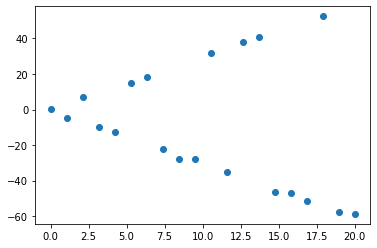

In [107]:
def generate_dataset(theta: np.ndarray, beta: np.ndarray, x: np.ndarray) -> np.ndarray:
    bern = sp.stats.bernoulli(0.5)
    y = np.array([])
    for i in range(len(xs)):
        z = bern.rvs()
        if (z == 0):
            norm1 = sp.stats.norm(np.dot(theta,x[i]), 1)
            y = np.append(y,norm1.rvs())
        else:
            norm2 = sp.stats.norm(np.dot(beta,x[i]), 1)
            y = np.append(y,norm2.rvs())
    return y
theta = np.array([-3])
beta = np.array([3])
xs = np.linspace(0, 20, num = 20)
y = generate_dataset(theta, beta,xs)
plt.scatter(xs, y)

### Problem 2b (15 pts)

Write a function that implements the conditional density
$$
p(y | x; \theta, \beta)
$$
assuming that each $y^i$ is conditionally independent of each other given $z_i$.


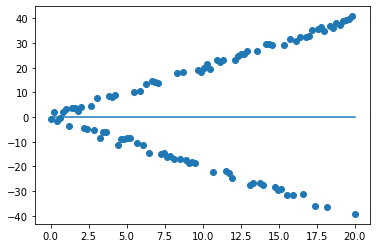

In [140]:
def mixture_model_density(theta: float, beta: float, X: np.ndarray, y: np.ndarray) -> float:
    # X is a one dimensional array of x values
    res = 1
    yIdx = 0
    for i in range(len(X)):
        norm1 = sp.stats.norm(loc=np.dot(theta,X[i]), scale=1.)
        norm2 = sp.stats.norm(loc=np.dot(beta,X[i]), scale=1.)
        res *= (0.5)*np.sum((norm1.pdf(y[yIdx]) + norm2.pdf(y[yIdx])))
        yIdx += 1
    return res
theta = np.array([2])
beta = np.array([-2])
xs = np.linspace(0, 20, num = 100)
y = generate_dataset(theta, beta,xs)
mixture_model_density(theta, beta, xs, y)

y_vals = [(.5* beta * val) + (.5*theta*val) for val in xs]
fig, ax = plt.subplots()
ax.scatter(xs, y)
ax.plot(xs, y_vals)

### Problem 2c (15 pts)

Write a function that finds the optimal parameters of $\theta$ and $\beta$, i.e., 
$$
\operatorname{argmin}_{\theta} p(y | x; \theta, \beta) \,.
$$
You can use `generate_dataset` to test if your code is working.

In [106]:
def solve_mixture_model_density(x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    # X contains a length N array of inputs of dimension 1
    # Y contains a length N array of outputs
#     theta = 0.0
#     beta = 0.0
    # TODO: FILL ME IN
    thetas = np.linspace(0.,1.)
    betas = np.linspace(0.,1.)
    best = mixture_model_density([0.5], [0.5], x, y) * -1
    besttheta = 0.5
    bestbeta = 0.5
    for theta in thetas:
        for beta in betas:
            curr = mixture_model_density(theta, beta, x, y) * -1
            if curr < best:
                best = curr
                besttheta = theta
                bestbeta = beta
    return besttheta, bestbeta
xs = np.linspace(0, 20, num = 20)
y = y
solve_mixture_model_density(xs,y)

(0.1020408163265306, 0.2040816326530612)

## Problem 3 (20 pts): Linear Regression, Duplicate Data

Suppose we have a dataset $(x_i, y_i)_{1 \leq i \leq N}$.
Suppose we duplicate this dataset so that it now contains a copy of each item.
Explain in words what happens to the weights of the linear regression in terms of the linear algebra solution and in terms of the probabilistic interpretation. Compare and contrast the two solutions. You can additionally write code and give experimental evidence as well.

In [115]:
xs = np.linspace(0, 20, num = 20)
xs = np.append(xs,xs)
# theta = np.array([-3])
# beta = np.array([3])
# xs = np.linspace(0, 20, num = 20)
y = generate_dataset(theta, beta,xs)

[ 0.          1.05263158  2.10526316  3.15789474  4.21052632  5.26315789
  6.31578947  7.36842105  8.42105263  9.47368421 10.52631579 11.57894737
 12.63157895 13.68421053 14.73684211 15.78947368 16.84210526 17.89473684
 18.94736842 20.          0.          1.05263158  2.10526316  3.15789474
  4.21052632  5.26315789  6.31578947  7.36842105  8.42105263  9.47368421
 10.52631579 11.57894737 12.63157895 13.68421053 14.73684211 15.78947368
 16.84210526 17.89473684 18.94736842 20.        ]


In [142]:
# One set of data
theta = np.array([1.,2.,3.])
x=np.array([[1.,2.],[3.,4.],[5.,6.]])
x_q = x.copy()
x_q = np.concatenate([x_q, np.ones((3, 1))], axis=1)
x_q[:,0] = f1(x_q[:,0])
x_q[:,1] = f2(x_q[:,1])
y = np.dot(x_q, theta)
X , Y = transform(f1, f2, x,y)
print("best weights: ", linear_algebra_solve(X, Y))

[[1. 2.]
 [3. 4.]
 [5. 6.]]
best weights:  [-30.  33. -28.]


In [144]:
# Duplicate Set of data
theta = np.array([1.,2.,3.])
x=np.array([[1.,2.],[3.,4.],[5.,6.]])
x = np.append(x,x,axis=0)
x_q = x.copy()
x_q = np.concatenate([x_q, np.ones((6, 1))], axis=1)
x_q[:,0] = f1(x_q[:,0])
x_q[:,1] = f2(x_q[:,1])
y = np.dot(x_q, theta)
X , Y = transform(f1, f2, x,y)
print("best weights: ", linear_algebra_solve(X, Y))

[[1. 2.]
 [3. 4.]
 [5. 6.]
 [1. 2.]
 [3. 4.]
 [5. 6.]]
best weights:  [-30.  33. -28.]


In [ ]:
def linear_algebra_solve(X, Y):
    X_p = np.concatenate([X, np.ones((Y.size[0], 1))], axis=1)
    return np.linalg.solve(X_p.transpose() @ X_p, X_p.transpose() @ Y)

The linear algebra solution produces the same weights due to the duplicated data producing duplicate y values. Thus when solving for Ax = b, we produce the same weights. We go from 3x2(x) @ 1x3 (ones) = 3x3(x/ones).

6x3(x.transpose) @ 3x6(x) @ (solution matrix) = 3x6(x.transpose) @ (6x1)y
produces a (3x1) y matrix. that is the same as the original solution with half the duplicated data. Since each row new row matches to its original y value.

For the probabilistic model, if we duplicate the data, we do not change the mean. Probablistic distributions are based on the mean of input data, so if the mean does not shift by adding new data, the optimal weights will also not shift.

In [171]:
data = [1,3,5,2,10,3]
print("mean of original data: ", np.mean(data))
print("mean of duplicate data: ", np.mean(np.append(data,data)))

mean of original data:  4.0
mean of duplicate data:  4.0


In [170]:
n = sp.stats.norm(loc = np.mean(data), scale=1)
n2 = sp.stats.norm(loc = np.mean(np.append(data,data)), scale=1)
v1 = n.rvs(100)
v2 = n2.rvs(100)
x = np.linspace(0, 100,100)

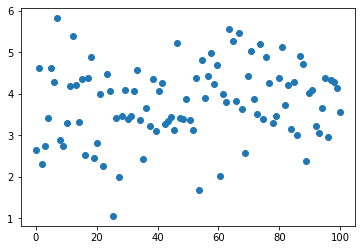

In [161]:
plt.scatter(x, v1)

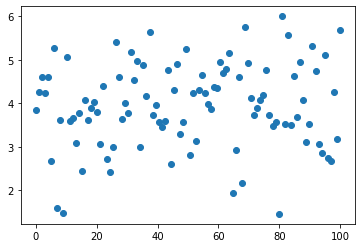

In [162]:
plt.scatter(x, v2)

FILL ME IN